In [1]:
from PARCv2 import PARCv2
from differentiator.advection import Advection
from differentiator.diffusion import Diffusion
from differentiator.differentiator import Differentiator
from differentiator.finitedifference import FiniteDifference
from differentiator.mappingandrecon import MappingAndRecon
from integrator.integrator import Integrator
from integrator.poisson import Poisson
from integrator.rk4 import RK4

In [2]:
import torch
from torchmetrics.functional.image import image_gradients
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchview import draw_graph

In [3]:
import os

os.environ["PATH"] += os.pathsep + "/home/xc7ts/softpack/bin"
os.environ["PATH"]

'/usr/local/lib/python3.10/dist-packages/torch_tensorrt/bin:/usr/local/mpi/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/ucx/bin:/opt/tensorrt/bin:/home/xc7ts/softpack/bin'

### Finite difference testing

In [4]:
image = torch.arange(0, 1*1*5*5, dtype=torch.float32).to("cuda")
image = torch.reshape(image, (1, 1, 5, 5))
dy, dx = image_gradients(image)
dy[0, 0, :, :]

tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [5]:
dx[0, 0, :, :]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]], device='cuda:0')

In [6]:
right_diff = FiniteDifference(padding_mode="replicate")
dy, dx = right_diff(image)
dy[0, 0, :, :]

tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [7]:
dx[0, 0, :, :]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]], device='cuda:0')

In [8]:
summary(right_diff, (8, 1, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
FiniteDifference                         [8, 1, 5, 5]              --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Advection testing

In [9]:
adv = Advection(right_diff)

In [10]:
data = np.load("/project/vil_baek/data/physics/transport_eqn_square/transport_eqn_square_64_1.00_8.00_8.00_1.00_2.00_8.00_120_0.10.npy")
adv_gt = (data[1, :, :, 0] - data[0, :, :, 0])/0.1

In [11]:
state_var = torch.permute(torch.tensor(data[0:1, :, :, 0:1], dtype=torch.float32), (0, 3, 1, 2)).cuda()
vel_var = torch.permute(torch.tensor(data[0:1, :, :, 1:], dtype=torch.float32), (0, 3, 1, 2)).cuda()
adv_parc = adv(state_var, vel_var)

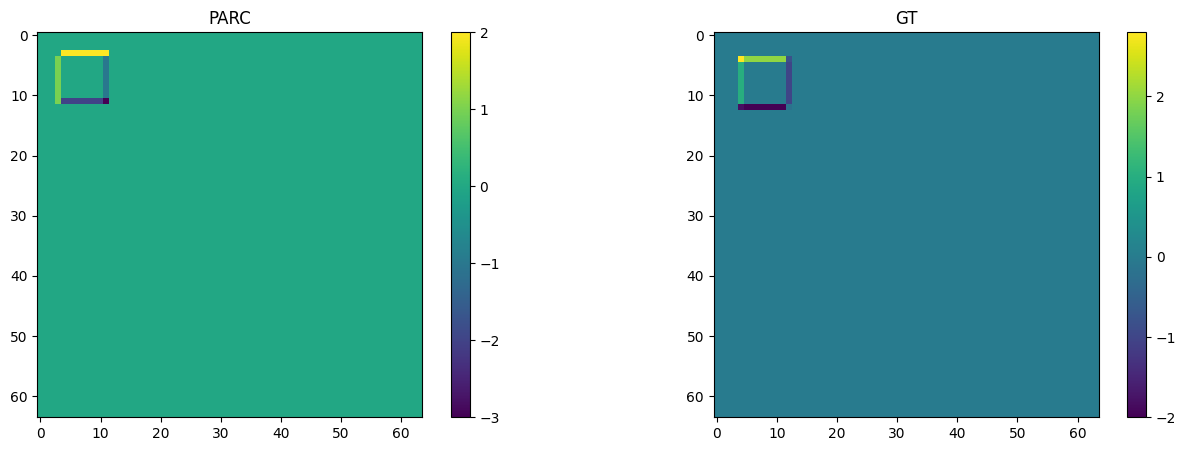

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(adv_parc.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(-adv_gt)
ax1.set_title("GT")
plt.colorbar(im1)

In [13]:
summary(adv, [(8, 1, 64, 128), (8,2, 64, 128)])

Layer (type:depth-idx)                   Output Shape              Param #
Advection                                [8, 1, 64, 128]           --
├─FiniteDifference: 1-1                  [8, 1, 64, 128]           --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.79
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.79

### Diffusion testing

In [14]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing='xy')
data = (xx**2.0)*(yy**3.0)
lap_gt = 2.0 * (yy**3.0) + (xx**2.0)*(6.0*yy)

In [15]:
dif = Diffusion(right_diff)
lap_parc = dif(torch.tensor(data.reshape(1, 1, 64, 64), dtype=torch.float32, device="cuda"))

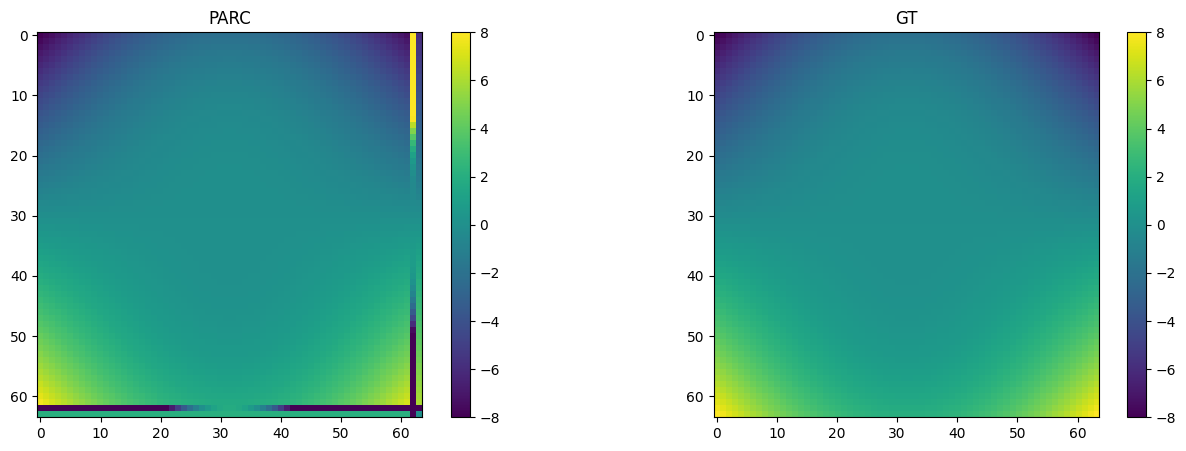

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(lap_parc.detach().cpu().numpy()[0, 0, :, :]*32*32, vmin=-8.0, vmax=8.0)
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(lap_gt)
ax1.set_title("GT")
plt.colorbar(im1)

### Poisson testing

In [17]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing='xy')
vec_x = (xx**2.0)*(yy**3.0)
vec_y = (xx**4.0)*(yy**5.0)
vec = torch.cat([torch.tensor(vec_x.reshape(1, 1, 64, 64), dtype=torch.float), torch.tensor(vec_y.reshape(1, 1, 64, 64), dtype=torch.float)], 1)
x_dx, x_dy = 2.0*xx*(yy**3.0), (xx**2.0)*3.0*(yy**2.0)
y_dx, y_dy = 4.0*(xx**3.0)*(yy**5.0), (xx**4.0)*5.0*(yy*4.0)

In [18]:
poi = Poisson(right_diff)
x_dx2, y_dy2, x_dxy_dy = poi(vec.cuda())

Text(0.5, 1.0, 'GT')

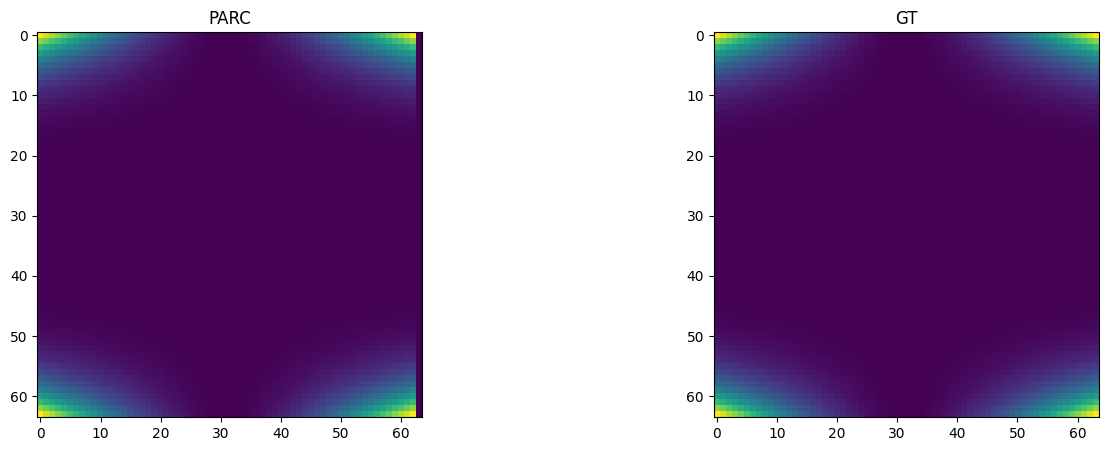

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dx2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx*x_dx)
ax1.set_title("GT")

Text(0.5, 1.0, 'GT')

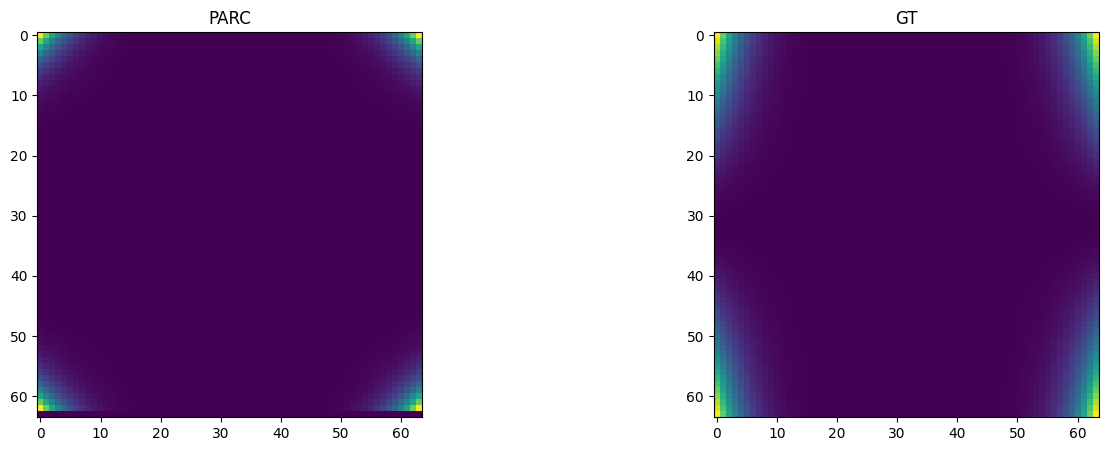

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(y_dy2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(y_dy*y_dy)
ax1.set_title("GT")

Text(0.5, 1.0, 'GT')

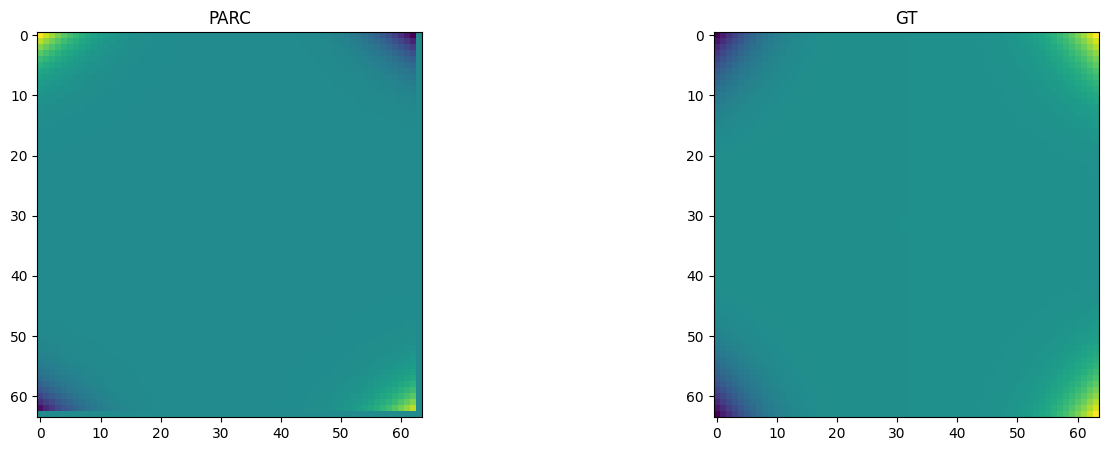

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dxy_dy.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx*y_dy)
ax1.set_title("GT")

### SPADE

In [22]:
from utilities.spade import SPADE


spade = SPADE(64, 2).cuda()
draw_graph(spade, input_size=[(8, 64, 128, 256), (8, 2, 128, 256)]).visual_graph.render("SPADE", directory="./doc" ,format='png')
summary(spade, [(8, 64, 128, 256), (8, 2, 128, 256)])

Layer (type:depth-idx)                   Output Shape              Param #
SPADE                                    [8, 64, 128, 256]         --
├─Sequential: 1-1                        [8, 64, 128, 256]         --
│    └─Conv2d: 2-1                       [8, 64, 128, 256]         1,216
│    └─ReLU: 2-2                         [8, 64, 128, 256]         --
├─Conv2d: 1-2                            [8, 64, 128, 256]         36,928
├─Conv2d: 1-3                            [8, 64, 128, 256]         36,928
Total params: 75,072
Trainable params: 75,072
Non-trainable params: 0
Total mult-adds (G): 19.68
Input size (MB): 69.21
Forward/backward pass size (MB): 402.65
Params size (MB): 0.30
Estimated Total Size (MB): 472.16

### Spade generator unit

In [23]:
from utilities.spade import SPADEGeneratorUnit

sgu = SPADEGeneratorUnit(64, 64, 2).cuda()
input_fe, input_explicit, input_rand = torch.randn(8, 64, 128, 256).cuda(), torch.randn(8, 2, 128, 256).cuda(), True
draw_graph(sgu, [input_fe, input_explicit, input_rand], depth=1).visual_graph.render("SPADEGeneratorUnit", directory="./doc" ,format='png')
summary(sgu, input_data=[input_fe, input_explicit, input_rand])

Layer (type:depth-idx)                   Output Shape              Param #
SPADEGeneratorUnit                       [8, 64, 128, 256]         --
├─SPADE: 1-1                             [8, 64, 128, 256]         --
│    └─Sequential: 2-1                   [8, 64, 128, 256]         --
│    │    └─Conv2d: 3-1                  [8, 64, 128, 256]         1,216
│    │    └─ReLU: 3-2                    [8, 64, 128, 256]         --
│    └─Conv2d: 2-2                       [8, 64, 128, 256]         36,928
│    └─Conv2d: 2-3                       [8, 64, 128, 256]         36,928
├─LeakyReLU: 1-2                         [8, 64, 128, 256]         --
├─Conv2d: 1-3                            [8, 64, 128, 256]         4,160
├─SPADE: 1-4                             [8, 64, 128, 256]         --
│    └─Sequential: 2-4                   [8, 64, 128, 256]         --
│    │    └─Conv2d: 3-3                  [8, 64, 128, 256]         1,216
│    │    └─ReLU: 3-4                    [8, 64, 128, 256]         -

### UNetUpBlock

In [24]:
from utilities.unet import UNetUpBlock

uup = UNetUpBlock(64, 32, use_concat=False).cuda()
draw_graph(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)]).visual_graph.render("UNetUpBlock_nocat", directory="./doc" ,format='png')
summary(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
UNetUpBlock                              [8, 32, 32, 64]           --
├─Upsample: 1-1                          [8, 64, 32, 64]           --
├─Sequential: 1-2                        [8, 32, 32, 64]           --
│    └─Conv2d: 2-1                       [8, 32, 32, 64]           18,464
│    └─LeakyReLU: 2-2                    [8, 32, 32, 64]           --
│    └─Conv2d: 2-3                       [8, 32, 32, 64]           1,056
│    └─LeakyReLU: 2-4                    [8, 32, 32, 64]           --
Total params: 19,520
Trainable params: 19,520
Non-trainable params: 0
Total mult-adds (M): 319.82
Input size (MB): 5.24
Forward/backward pass size (MB): 8.39
Params size (MB): 0.08
Estimated Total Size (MB): 13.71

In [25]:
uup = UNetUpBlock(64, 32, skip_channels=64, use_concat=True).cuda()
draw_graph(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)]).visual_graph.render("UNetUpBlock_cat", directory="./doc" ,format='png')
summary(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
UNetUpBlock                              [8, 32, 32, 64]           --
├─Upsample: 1-1                          [8, 64, 32, 64]           --
├─Sequential: 1-2                        [8, 32, 32, 64]           --
│    └─Conv2d: 2-1                       [8, 32, 32, 64]           36,896
│    └─LeakyReLU: 2-2                    [8, 32, 32, 64]           --
│    └─Conv2d: 2-3                       [8, 32, 32, 64]           1,056
│    └─LeakyReLU: 2-4                    [8, 32, 32, 64]           --
Total params: 37,952
Trainable params: 37,952
Non-trainable params: 0
Total mult-adds (M): 621.81
Input size (MB): 5.24
Forward/backward pass size (MB): 8.39
Params size (MB): 0.15
Estimated Total Size (MB): 13.78

### UNetDownBlock

In [26]:
from utilities.unet import UNetDownBlock

udown = UNetDownBlock(64, 128)
draw_graph(udown, input_size=(8, 64, 128, 256)).visual_graph.render("UNetDownBlock", directory="./doc" ,format='png')
summary(udown, input_size=(8, 64, 128, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNetDownBlock                            [8, 128, 64, 128]         --
├─MaxPool2d: 1-1                         [8, 64, 64, 128]          --
├─Sequential: 1-2                        [8, 128, 64, 128]         --
│    └─Conv2d: 2-1                       [8, 128, 64, 128]         73,856
│    └─LeakyReLU: 2-2                    [8, 128, 64, 128]         --
│    └─Conv2d: 2-3                       [8, 128, 64, 128]         16,512
│    └─LeakyReLU: 2-4                    [8, 128, 64, 128]         --
Total params: 90,368
Trainable params: 90,368
Non-trainable params: 0
Total mult-adds (G): 5.92
Input size (MB): 67.11
Forward/backward pass size (MB): 134.22
Params size (MB): 0.36
Estimated Total Size (MB): 201.69

### UNet

In [27]:
from utilities.unet import UNet

unet = UNet([64, 64*2, 64*4, 64*8, 64*16], 5, 128, up_block_use_concat=[False, True, False, True], skip_connection_indices=[2, 0])
draw_graph(unet, input_size=(8, 5, 128, 192), depth=1).visual_graph.render("UNet_em", directory="./doc" ,format='png')
summary(unet, input_size=(8, 5, 128, 192))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 128, 128, 192]        --
├─Sequential: 1-1                        [8, 64, 128, 192]         --
│    └─Conv2d: 2-1                       [8, 64, 128, 192]         2,944
│    └─LeakyReLU: 2-2                    [8, 64, 128, 192]         --
│    └─Conv2d: 2-3                       [8, 64, 128, 192]         4,160
│    └─LeakyReLU: 2-4                    [8, 64, 128, 192]         --
├─ModuleList: 1-2                        --                        --
│    └─UNetDownBlock: 2-5                [8, 128, 64, 96]          --
│    │    └─MaxPool2d: 3-1               [8, 64, 64, 96]           --
│    │    └─Sequential: 3-2              [8, 128, 64, 96]          90,368
│    └─UNetDownBlock: 2-6                [8, 256, 32, 48]          --
│    │    └─MaxPool2d: 3-3               [8, 128, 32, 48]          --
│    │    └─Sequential: 3-4              [8, 256, 32, 48]          360,960


In [28]:
unet = UNet([64, 64*2, 64*4], 5, 64, up_block_use_concat=[False, True], skip_connection_indices=[0])
draw_graph(unet, input_size=(8, 5, 128, 192), depth=1).visual_graph.render("UNet_burger", directory="./doc" ,format='png')
summary(unet, input_size=(8, 5, 128, 192))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 64, 128, 192]         --
├─Sequential: 1-1                        [8, 64, 128, 192]         --
│    └─Conv2d: 2-1                       [8, 64, 128, 192]         2,944
│    └─LeakyReLU: 2-2                    [8, 64, 128, 192]         --
│    └─Conv2d: 2-3                       [8, 64, 128, 192]         4,160
│    └─LeakyReLU: 2-4                    [8, 64, 128, 192]         --
├─ModuleList: 1-2                        --                        --
│    └─UNetDownBlock: 2-5                [8, 128, 64, 96]          --
│    │    └─MaxPool2d: 3-1               [8, 64, 64, 96]           --
│    │    └─Sequential: 3-2              [8, 128, 64, 96]          90,368
│    └─UNetDownBlock: 2-6                [8, 256, 32, 48]          --
│    │    └─MaxPool2d: 3-3               [8, 128, 32, 48]          --
│    │    └─Sequential: 3-4              [8, 256, 32, 48]          360,960


### Resnet Block

In [29]:
from utilities.resnet import ResNetBlock

resnet_block = ResNetBlock(64, 64, 3, "constant")
draw_graph(resnet_block, input_size=(8, 64, 128, 256)).visual_graph.render("ResNetBlock", directory="./doc" ,format='png')
summary(resnet_block, input_size=(8, 64, 128, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetBlock                              [8, 64, 128, 256]         --
├─Sequential: 1-1                        [8, 64, 128, 256]         --
│    └─Conv2d: 2-1                       [8, 64, 128, 256]         36,928
│    └─ReLU: 2-2                         [8, 64, 128, 256]         --
├─Sequential: 1-2                        [8, 64, 128, 256]         --
│    └─Conv2d: 2-3                       [8, 64, 128, 256]         36,928
│    └─ReLU: 2-4                         [8, 64, 128, 256]         --
├─Identity: 1-3                          [8, 64, 128, 256]         --
├─ReLU: 1-4                              [8, 64, 128, 256]         --
Total params: 73,856
Trainable params: 73,856
Non-trainable params: 0
Total mult-adds (G): 19.36
Input size (MB): 67.11
Forward/backward pass size (MB): 268.44
Params size (MB): 0.30
Estimated Total Size (MB): 335.84

### Resnet

In [30]:
from utilities.resnet import ResNet


resnet = ResNet(32, [128, 128], 1, False)
draw_graph(resnet, input_size=(8, 32, 128, 256), depth=2).visual_graph.render("ResNet", directory="./doc" ,format='png')
summary(resnet, input_size=(8, 32, 128, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 128, 128, 256]        --
├─Sequential: 1-1                        [8, 128, 128, 256]        --
│    └─Conv2d: 2-1                       [8, 128, 128, 256]        4,224
│    └─ReLU: 2-2                         [8, 128, 128, 256]        --
├─Sequential: 1-2                        [8, 128, 128, 256]        --
│    └─Conv2d: 2-3                       [8, 128, 128, 256]        16,512
│    └─ReLU: 2-4                         [8, 128, 128, 256]        --
├─Sequential: 1-3                        [8, 128, 128, 256]        --
│    └─ResNetBlock: 2-5                  [8, 128, 128, 256]        --
│    │    └─Sequential: 3-1              [8, 128, 128, 256]        16,512
│    │    └─Sequential: 3-2              [8, 128, 128, 256]        16,512
│    │    └─Identity: 3-3                [8, 128, 128, 256]        --
│    │    └─ReLU: 3-4                    [8, 128, 128, 256]        --


In [31]:
resnet = ResNet(32, [64, 128, 256], 3, True)
draw_graph(resnet, input_size=(8, 32, 128, 256), depth=2).visual_graph.render("ResNet_down", directory="./doc" ,format='png')

'doc/ResNet_down.png'

### Mapping And Recon

In [32]:
mar = MappingAndRecon(128, 2, 1, "constant")
draw_graph(mar, input_size=[(8, 128, 128, 192), (8, 2, 128, 192)]).visual_graph.render("MappingAndRecon_2_2", directory="./doc" ,format='png')
summary(mar, input_size=[(8, 128, 128, 192), (8, 2, 128, 192)])

Layer (type:depth-idx)                   Output Shape              Param #
MappingAndRecon                          [8, 1, 128, 192]          --
├─SPADEGeneratorUnit: 1-1                [8, 128, 128, 192]        --
│    └─SPADE: 2-1                        [8, 128, 128, 192]        --
│    │    └─Sequential: 3-1              [8, 128, 128, 192]        2,432
│    │    └─Conv2d: 3-2                  [8, 128, 128, 192]        147,584
│    │    └─Conv2d: 3-3                  [8, 128, 128, 192]        147,584
│    └─LeakyReLU: 2-2                    [8, 128, 128, 192]        --
│    └─Conv2d: 2-3                       [8, 128, 128, 192]        16,512
│    └─SPADE: 2-4                        [8, 128, 128, 192]        --
│    │    └─Sequential: 3-4              [8, 128, 128, 192]        2,432
│    │    └─Conv2d: 3-5                  [8, 128, 128, 192]        147,584
│    │    └─Conv2d: 3-6                  [8, 128, 128, 192]        147,584
│    └─LeakyReLU: 2-5                    [8, 128, 128, 

### Differentiator

In [33]:
# EM: T, p, mu, u, v
# Adv: all vars
# Dif: T only
n_fe_features = 128
unet_em = UNet([64, 64*2, 64*4, 64*8, 64*16], 5, n_fe_features, up_block_use_concat=[False, True, False, True], skip_connection_indices=[2, 0]).cuda()
diff_em = Differentiator(3,                 # 3 state variables: T, p, mu. We always assume 2 velocity being the last 2 channels 
                         n_fe_features,     # Number of features returned by the feature extraction network
                         [0, 1, 2, 3, 4],   # Channel indices to calculate advection
                         [0],               # Channel indices to calculate diffusion
                         unet_em,           # Feature extraction network
                         "constant",        # Padding mode
                         right_diff         # Finite difference method
                        ).cuda()
draw_graph(diff_em, input_size=(8, 5, 128, 192), depth=1).visual_graph.render("Diff_em", directory="./doc" ,format='png')
summary(diff_em, input_size=(8, 5, 128, 192))

Layer (type:depth-idx)                             Output Shape              Param #
Differentiator                                     [8, 5, 128, 192]          --
├─UNet: 1-1                                        [8, 128, 128, 192]        --
│    └─Sequential: 2-1                             [8, 64, 128, 192]         --
│    │    └─Conv2d: 3-1                            [8, 64, 128, 192]         2,944
│    │    └─LeakyReLU: 3-2                         [8, 64, 128, 192]         --
│    │    └─Conv2d: 3-3                            [8, 64, 128, 192]         4,160
│    │    └─LeakyReLU: 3-4                         [8, 64, 128, 192]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └─UNetDownBlock: 3-5                     [8, 128, 64, 96]          90,368
│    │    └─UNetDownBlock: 3-6                     [8, 256, 32, 48]          360,960
│    │    └─UNetDownBlock: 3-7                     [8, 512, 16, 24]          1,442,816
│    │    └─U

In [34]:
# Burgers: u, v
# Adv: all vars
# Dif: all vars
n_fe_features = 64
unet_burgers = UNet([64, 64*2, 64*4], 3, n_fe_features, up_block_use_concat=[False, True], skip_connection_indices=[0])
diff_burgers = Differentiator(1,                 # 1 state variables: mu. We always assume 2 velocity being the last 2 channels 
                              n_fe_features,     # Number of features returned by the feature extraction network
                              [1, 2],            # Channel indices to calculate advection
                              [1, 2],            # Channel indices to calculate diffusion
                              unet_burgers,      # Feature extraction network
                              "constant",        # Padding mode
                              right_diff         # Finite difference method
                             ).cuda()
draw_graph(diff_burgers, input_size=(8, 3, 64, 64), depth=1).visual_graph.render("Diff_burgers", directory="./doc" ,format='png')
summary(diff_burgers, input_size=(8, 3, 64, 64))

Layer (type:depth-idx)                             Output Shape              Param #
Differentiator                                     [8, 3, 64, 64]            --
├─UNet: 1-1                                        [8, 64, 64, 64]           --
│    └─Sequential: 2-1                             [8, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                            [8, 64, 64, 64]           1,792
│    │    └─LeakyReLU: 3-2                         [8, 64, 64, 64]           --
│    │    └─Conv2d: 3-3                            [8, 64, 64, 64]           4,160
│    │    └─LeakyReLU: 3-4                         [8, 64, 64, 64]           --
│    └─ModuleList: 2-2                             --                        --
│    │    └─UNetDownBlock: 3-5                     [8, 128, 32, 32]          90,368
│    │    └─UNetDownBlock: 3-6                     [8, 256, 16, 16]          360,960
│    └─ModuleList: 2-3                             --                        --
│    │    └─UNetUpBl

In [35]:
# N-S: p, re, u, v
# Adv: u, v
# Dif: u, vs
n_fe_features = 128
unet_ns = UNet([64, 64*2, 64*4, 64*8, 64*16], 4, n_fe_features, up_block_use_concat=[False, True, False, True], skip_connection_indices=[2, 0]).cuda()
diff_ns = Differentiator(2,                 # 2 state variables: p, re. We always assume 2 velocity being the last 2 channels 
                              n_fe_features,     # Number of features returned by the feature extraction network
                              [2, 3],            # Channel indices to calculate advection
                              [2, 3],            # Channel indices to calculate diffusion
                              unet_ns,      # Feature extraction network
                              "constant",        # Padding mode
                              right_diff         # Finite difference method
                             ).cuda()
draw_graph(diff_ns, input_size=(8, 4, 128, 256), depth=1).visual_graph.render("Diff_ns", directory="./doc" ,format='png')
summary(diff_ns, input_size=(8, 4, 128, 256))

Layer (type:depth-idx)                             Output Shape              Param #
Differentiator                                     [8, 4, 128, 256]          --
├─UNet: 1-1                                        [8, 128, 128, 256]        --
│    └─Sequential: 2-1                             [8, 64, 128, 256]         --
│    │    └─Conv2d: 3-1                            [8, 64, 128, 256]         2,368
│    │    └─LeakyReLU: 3-2                         [8, 64, 128, 256]         --
│    │    └─Conv2d: 3-3                            [8, 64, 128, 256]         4,160
│    │    └─LeakyReLU: 3-4                         [8, 64, 128, 256]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └─UNetDownBlock: 3-5                     [8, 128, 64, 128]         90,368
│    │    └─UNetDownBlock: 3-6                     [8, 256, 32, 64]          360,960
│    │    └─UNetDownBlock: 3-7                     [8, 512, 16, 32]          1,442,816
│    │    └─U

### Poisson block

In [36]:
from integrator.poisson import PoissonBlock


poi_block = PoissonBlock(3, right_diff)
draw_graph(poi_block, input_size=(8, 3, 128, 256), depth=1).visual_graph.render("PoissonBlock", directory="./doc" ,format='png')
summary(poi_block, input_size=(8, 3, 128, 256))

Layer (type:depth-idx)                        Output Shape              Param #
PoissonBlock                                  [8, 1, 128, 256]          --
├─Poisson: 1-1                                [8, 1, 128, 256]          --
│    └─FiniteDifference: 2-1                  [8, 1, 128, 256]          --
│    └─FiniteDifference: 2-2                  [8, 1, 128, 256]          --
├─Sequential: 1-2                             [8, 1, 128, 256]          --
│    └─Conv2d: 2-3                            [8, 64, 128, 256]         3,520
│    └─LeakyReLU: 2-4                         [8, 64, 128, 256]         --
│    └─Conv2d: 2-5                            [8, 64, 128, 256]         4,160
│    └─LeakyReLU: 2-6                         [8, 64, 128, 256]         --
│    └─ResNet: 2-7                            [8, 64, 128, 256]         --
│    │    └─Sequential: 3-1                   [8, 64, 128, 256]         36,928
│    │    └─Sequential: 3-2                   [8, 64, 128, 256]         36,928
│    │

### Numerical integrators

In [37]:
from integrator.rk4 import RK4


rk4_int = RK4()
cdiff = FiniteDifference(filter_1d=np.array([-1.0, 0.0, 1.0], dtype=np.float32)*0.5, padding_mode="circular")
diff_func = lambda x: -1e2*torch.sum(torch.cat(cdiff(x), 1), 1, keepdim=True)
step_size = 1e-3
res = []
x, y = np.linspace(-3.0, 3.0, 600), np.linspace(-3.0, 3.0, 600)
xx, yy = np.meshgrid(x, y)
ic = torch.tensor(np.exp(-0.5*xx*xx-0.5*yy*yy), dtype=torch.float32).cuda().unsqueeze(0).unsqueeze(0)
current = ic
for _ in range(2000):
    current, _ = rk4_int(diff_func, current, step_size)
    res.append(current[0, 0, :, :].detach().cpu().numpy())

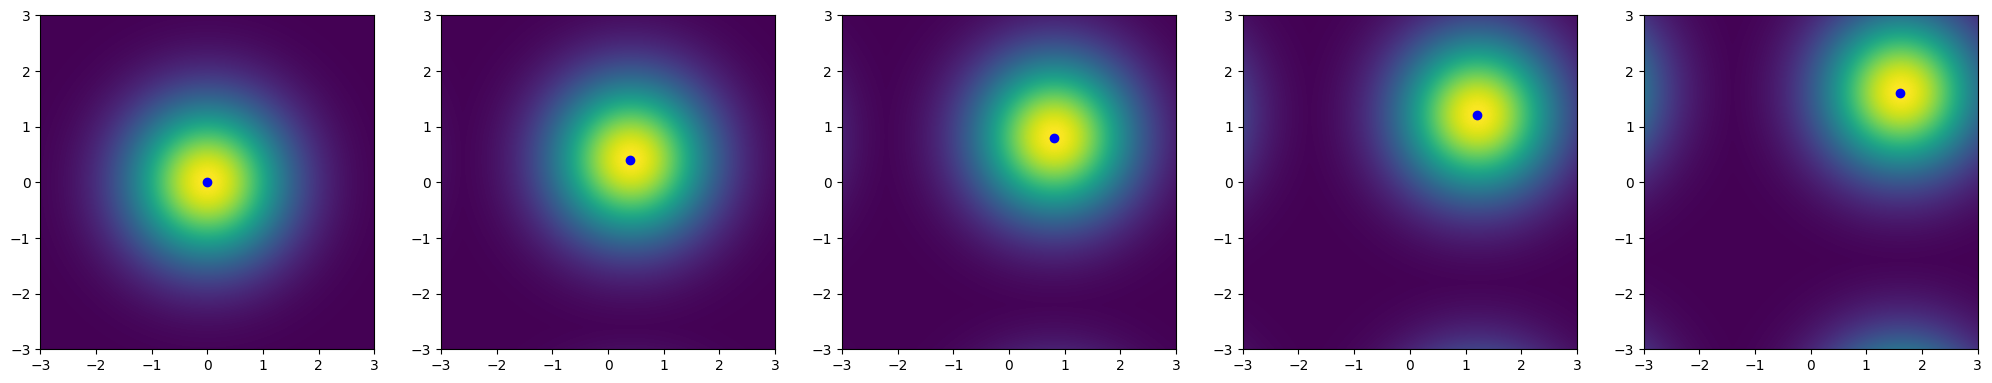

In [38]:
fig, ax = plt.subplots(1, 5, figsize=(25,6))
for i in range(5):
    ax[i].imshow(res[i*400], origin="lower", extent=(-3.0, 3.0, -3.0, 3.0))
    ax[i].plot(i*400*1e-3, i*400*1e-3, "bo")

### Integrators

In [39]:
# No Poisson blocks


def transport_parc_int(x):
    t_dot = torch.zeros_like(x)
    dt_dy, dt_dx = cdiff(x[:, 0:1, :, :])
    adv_t = torch.sum(dt_dx * x[:, 1:2, :, :] + dt_dy * x[:, 2:3, :, :], 1, keepdim=True) * 1e2
    t_dot[:, 0, :, :] = -adv_t
    return t_dot


integrator = Integrator(False, [], rk4_int, [None], "constant", cdiff)
ic_parc = torch.cat([ic, torch.ones_like(ic), torch.ones_like(ic)], 1)
t1 = (torch.tensor(range(1999), dtype=torch.float32).cuda() + 1.0) * step_size
res = integrator(transport_parc_int, ic_parc, 0.0, t1)

In [40]:
res.shape

torch.Size([1999, 1, 3, 600, 600])

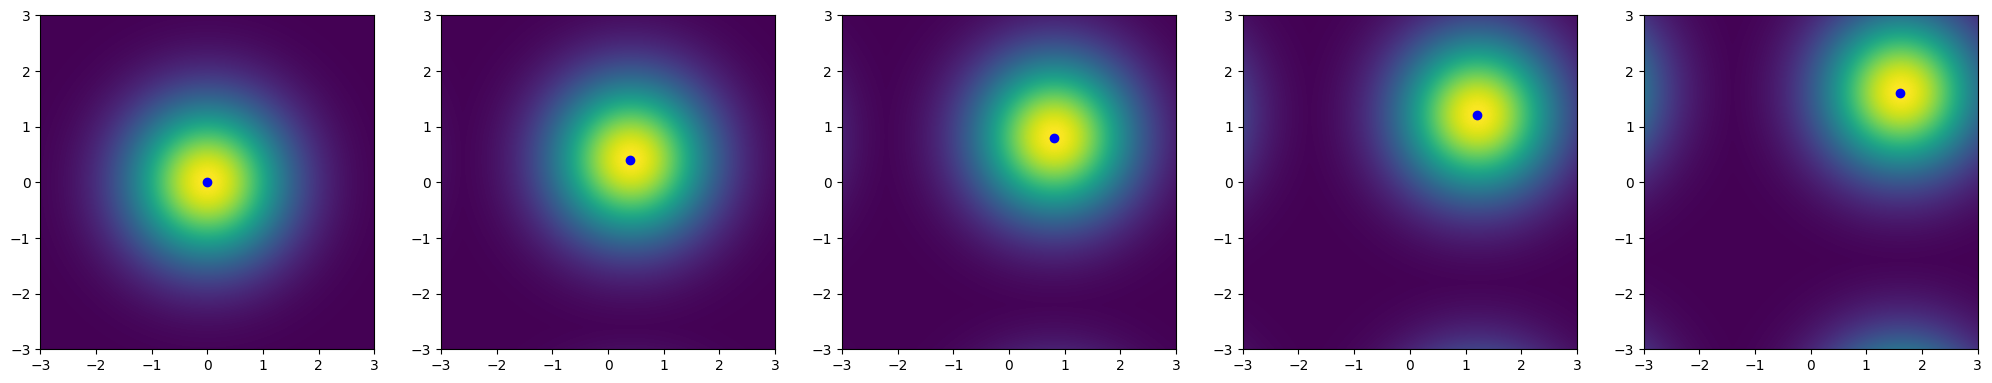

In [41]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))
for i in range(5):
    ax[i].imshow(res[i*400, 0, 0, :, :].detach().cpu().numpy(), origin="lower", extent=(-3.0, 3.0, -3.0, 3.0))
    ax[i].plot(i*400*1e-3, i*400*1e-3, "bo")

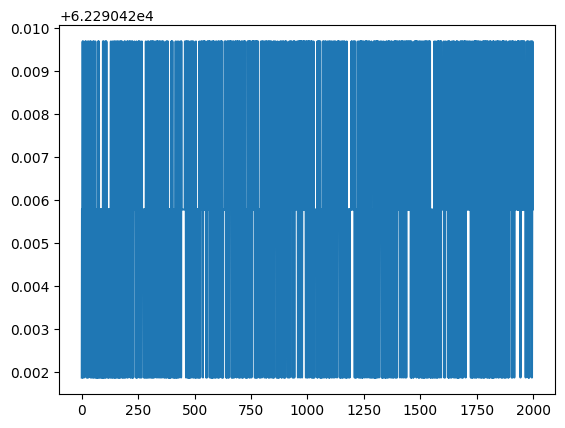

In [42]:
conservation_law = torch.sum(res[:, 0, 0, :, :], (1, 2))
plt.plot(conservation_law.detach().cpu().numpy())

In [43]:
# With Poisson blocks
# N-S
# 2 state variables: p, re, u, v
# p is entirely determined by Poisson block
ic = torch.randn((8, 4, 128, 256)).cuda()
t1 = (torch.tensor(range(1), dtype=torch.float32).cuda() + 1.0) / 40.0
integrator_ns = Integrator(True, [(1, 2, 3, 0)], rk4_int, [None, None, None, None], "constant", right_diff).cuda()
draw_graph(integrator_ns, input_data=[diff_ns, ic, 0.0, t1], depth=2, roll=True).visual_graph.render("Integrator_w_poisson", directory="./doc" ,format='png')

'doc/Integrator_w_poisson.png'

### PARCv2

In [46]:
# EM
integrator_em = integrator_ns = Integrator(True, [], rk4_int, [None, None, None, None, None], "constant", right_diff).cuda()
loss = torch.nn.L1Loss()
parcv2_em = PARCv2(diff_em, integrator_em, loss)

ic = torch.randn((1, 5, 128, 256))
t1 = (torch.tensor(range(4), dtype=torch.float32).cuda() + 1.0) / 40.0

draw_graph(parcv2_em, input_data=[ic, 0.0, t1], depth=2, roll=True).visual_graph.render("PARCv2", directory="./doc" ,format='png')

'doc/PARCv2.png'